# **ORB Feature Matcher**

This notebook walks you through how ORB works and tests the `orb_matcher` to filter out unrelated input images before building a 3D mesh.

<br>

---

### 🔍 What is ORB?

- ORB (Oriented FAST and Rotated BRIEF) is a lightweight, real-time feature detection method. It’s optimized for speed and low memory usage—perfect for fast image filtering.  
- Bonus: it’s open-source and free from licensing restrictions (unlike SIFT or SURF).


### 🤔 Why Do We Need ORB?

- When uploading input images, it’s easy to accidentally include an unrelated one (say, a photo of your cat). That could break your mesh reconstruction.
- ORB compares key visual features and filters out mismatches—so your model only sees what matters.


### ⚙️ How Does ORB Work?

- Even if your images have different angles, lighting, or devices, ORB can detect shared patterns across them.
- It uses FAST to find keypoints, Harris scoring to rank them, and BRIEF (with rotation invariance) to describe them.
- That way, ORB preserves the real-world structure and ignores the visual noise.

**P.S.** If you want to dive deeper into how ORB compares to SIFT and SURF? Check out this article [A Comparison of SIFT, SURF, and ORB on OpenCV](https://mikhail-kennerley.medium.com/a-comparison-of-sift-surf-and-orb-on-opencv-59119b9ec3d0)

---

<br>

### 🧪 Time to Put It to the Test!

We’re going to explore how ORB works step by step, and then implement our own `orb_matcher` to filter the images. Here’s the plan:

1. ✅ Check the images  
2. ✅ Detect keypoints using FAST  
3. ✅ Rank keypoints with Harris score  
4. ✅ Compute descriptors using ORB (Rotated BRIEF)  
5. ✅ Match keypoints between images  
6. ✅ Test our `orb_matcher` filtering logic  

---

## **1. Check the images**

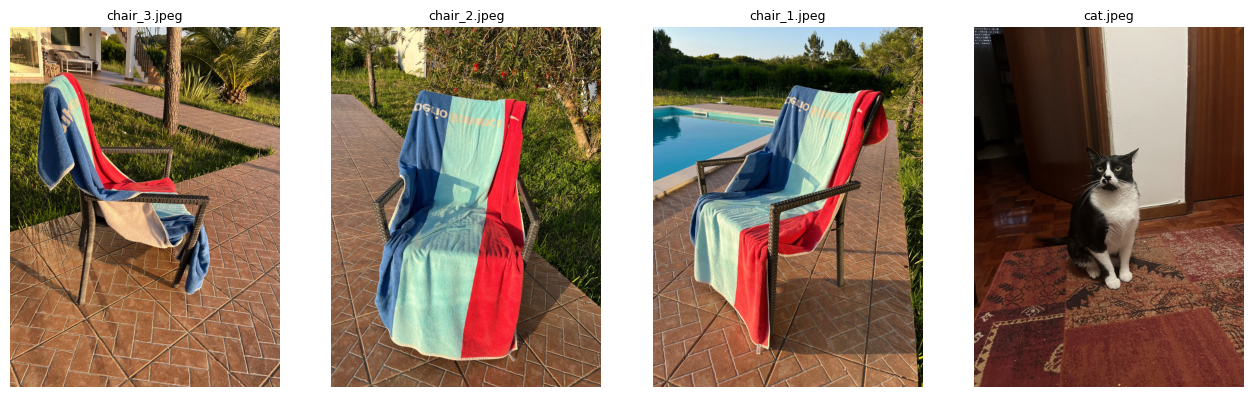

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Path to the images
image_dir = '../test_images'
image_files = sorted(
    [f for f in os.listdir(image_dir) if f.endswith('.jpeg')],
    reverse=True
)

# Read the images
images = []
for file in image_files:
    path = os.path.join(image_dir, file)
    img = cv.imread(path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB for matplotlib
    images.append((file, img_rgb))  # Save filename and image

# Plot the images
fig, axs = plt.subplots(1, len(images), figsize=(13, 4))
for ax, (filename, img) in zip(axs, images):
    ax.imshow(img)
    ax.set_title(filename, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()


> I’ve got 3 images of a chair with a towel that I want to mesh for my game. But while feeding them into the program, **I accidentally tossed in a photo of my cat... Let’s see how ORB reacts.**

## **2. Detect keypoints using FAST**

Before ORB can compare images, it needs to find the keypoints—distinctive spots in each image, like corners or textured regions.

To do that quickly, it uses FAST (Features from Accelerated Segment Test), a super fast algorithm designed for real-time detection with minimal computation. It gives us a rough but efficient set of feature candidates to work with.

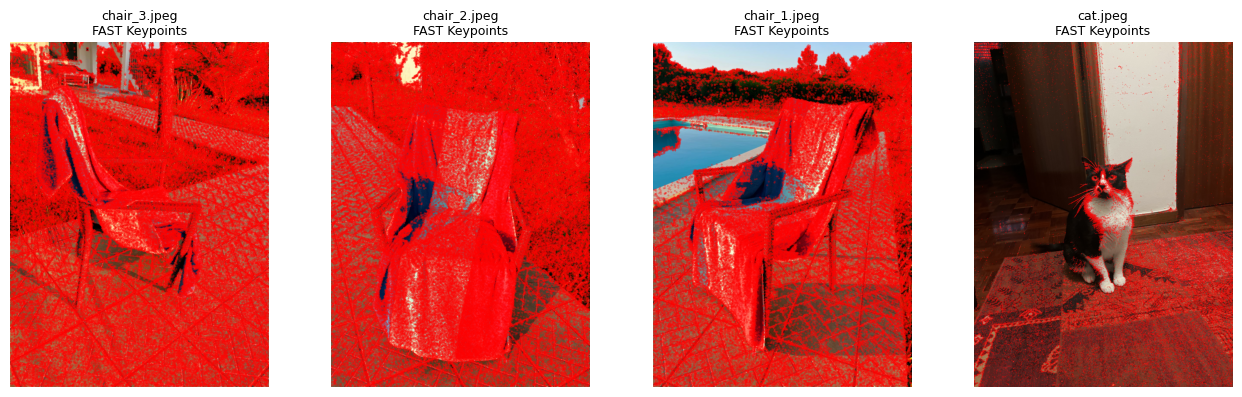

In [2]:
# Convert RGB images to grayscale for FAST keypoint detection
gray_images = [(fname, cv.cvtColor(img, cv.COLOR_RGB2GRAY)) for fname, img in images]

# Initialize FAST detector
fast = cv.FastFeatureDetector_create()

# Detect keypoints for each image
keypoints = []
for _, gray in gray_images:
    kp = fast.detect(gray, None)
    keypoints.append(kp)

# Draw keypoints on the original RGB images
images_with_kp = [
    cv.drawKeypoints(img, kp, None, color=(255, 0, 0))
    for (_, img), kp in zip(images, keypoints)
]

# Plot the results
fig, axs = plt.subplots(1, len(images), figsize=(13, 4))
for ax, (filename, img_with_kp) in zip(axs, zip(image_files, images_with_kp)):
    ax.imshow(img_with_kp)
    ax.set_title(f'{filename}\nFAST Keypoints', fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## **3. Rank Keypoints using Harris Score**

Now that we've found a bunch of potential keypoints with FAST, it's time to figure out which ones are actually useful.

FAST is fast (as the name says), but it's not picky - **it may detect too many weak or unstable points as we can see in the chair pictures**. To refine our selection, we score each keypoint using the Harris corner measure, which tells us how corner-like a point is (strong corners = better features).

By ranking all the detected points with this score, we can keep only the top keypoints that are most likely to be stable and distinctive—ideal for matching across images.

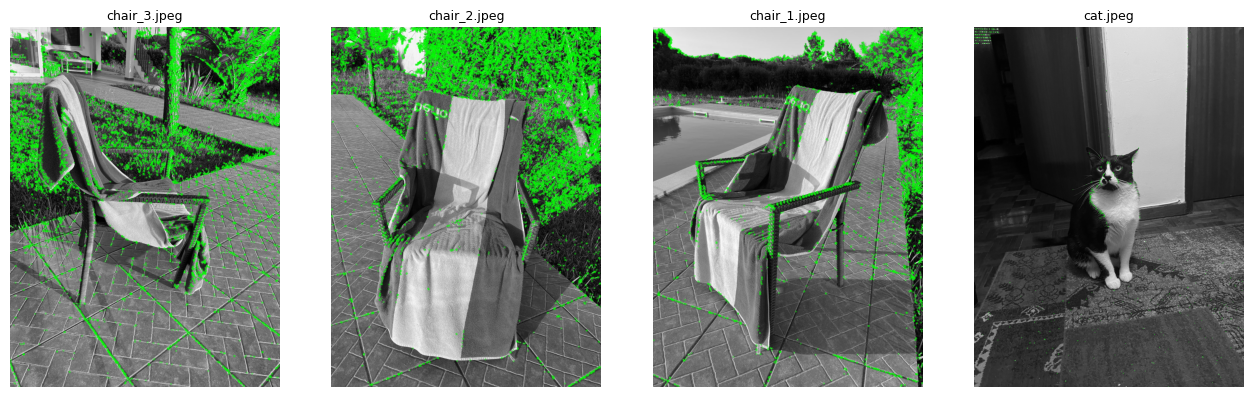

In [ ]:
def harris_keypoint_rank(
    img: np.ndarray,
    keypoints: list[cv.KeyPoint],
    threshold_ratio: float = 0.01
) -> list[cv.KeyPoint]:
    """
    Filters keypoints using Harris corner response and returns only strong keypoints.

    Params:

    img : np.ndarray
        Grayscale image (uint8).
    keypoints : list[cv.KeyPoint]
        Keypoints detected by a feature detector (e.g., FAST).
    threshold_ratio : float, optional
        Fraction of max Harris score to consider as strong corner (default 0.01).

    Returns: list[cv.KeyPoint]
        Filtered keypoints with strong Harris response.
    """
    gray = np.float32(img)

    harris_response = cv.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    harris_response = cv.dilate(harris_response, None)

    # Normalize for consistent thresholding
    max_response = harris_response.max()
    threshold = threshold_ratio * max_response

    # Retain keypoints with strong Harris response
    strong_kp = []
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        if 0 <= y < harris_response.shape[0] and 0 <= x < harris_response.shape[1]:
            if harris_response[y, x] > threshold:
                kp.response = harris_response[y, x]
                strong_kp.append(kp)

    return strong_kp

# Apply FAST and Harris ranking to all images
fast = cv.FastFeatureDetector_create()

threshold_ratio = 0.01
ranked_results = []
for filename, img_rgb in images:
    img_gray = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)
    keypoints = fast.detect(img_gray, None)
    ranked_kp = harris_keypoint_rank(img_gray, keypoints, threshold_ratio=threshold_ratio)
    img_with_top_kp = cv.drawKeypoints(img_gray, ranked_kp, None, color=(0, 255, 0))
    ranked_results.append((filename, img_with_top_kp))

# Plot the top keypoints
fig, axs = plt.subplots(1, len(ranked_results), figsize=(13, 4))
for ax, (filename, img_kp) in zip(axs, ranked_results):
    ax.imshow(img_kp, cmap='gray')
    ax.set_title(filename, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## **4. Rank descriptors using ORB (Rotated Brief)**

## **5. Match keypoints between images**

## **6. Test our `orb_matcher` filtering logic**